## LSTM AutoEncoders :

References : <br>  https://github.com/VivekPa/AIAlpha  <br>  https://medium.com/analytics-vidhya/using-machine-learning-to-predict-stock-prices-c4d0b23b029a  <br>  https://github.com/borisbanushev/stockpredictionai#thedata  <br>  https://github.com/borisbanushev/stockpredictionai  <br>  https://towardsdatascience.com/aifortrading-2edd6fac689d  <br>  https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html  <br>  https://github.com/zhiruiwang/LSTM_stock_price_prediction/blob/master/code.ipynb  <br>  https://github.com/amunategui/CVAE-Financial-Anomaly-Detection/blob/master/Financial%20Compliance%20and%20Fraud%20Detection%20with%20Conditional%20Variational%20Autoencoders%20(CVAE)%20and%20Tensorflow.ipynb  <br>  https://amunategui.github.io/cvae-in-finance/index.html  <br>  https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0180944

## Import Data from Yahoo Finance fr Apple Inc.

Here we will download the financial data for Apple Inc. Stock Prices for the Duration of 1st January 2013 to 1st December 2018 from Yahoo Finance Stock Data and convert it into a pandas DataFrame for furhter analysis using LSTM Autoencoders.

In [1]:
import pandas_datareader.data as pdr
import fix_yahoo_finance as fix
fix.pdr_override()


class GetData:
    def __init__(self, ticker, start, end):
        self.ticker = ticker
        self.start = start
        self.end = end

    # get stock data
    def get_stock_data(self):
        stock_data_MSFT = pdr.get_data_yahoo(self.ticker, self.start, self.end)
        stock_data_MSFT.to_csv("stock_data_MSFT.csv")

if __name__ == "__main__":
    data = GetData("MSFT", "2013-01-01", "2018-12-01")
data.get_stock_data()

[*********************100%***********************]  1 of 1 downloaded


Here we will use a date parser function for converting timestamps into dates for ease of use in the code.

In [2]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

## Import Libraries and Packages

In [3]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Import pandas .csv file and display its head

In [4]:
stock_data_MSFT = pd.read_csv('stock_data_MSFT.csv', header=0, parse_dates=[0], date_parser=parser)
stock_data_MSFT.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,27.25,27.73,27.15,27.62,23.67,52899300
1,2013-01-03,27.63,27.65,27.16,27.25,23.35,48294400
2,2013-01-04,27.27,27.34,26.73,26.74,22.92,52521100
3,2013-01-07,26.77,26.88,26.64,26.69,22.87,37110400
4,2013-01-08,26.75,26.79,26.46,26.55,22.75,44703100


## Plot the Stock Market Graph for Apple Inc. for given duration

C:\Users\NEERAJ\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


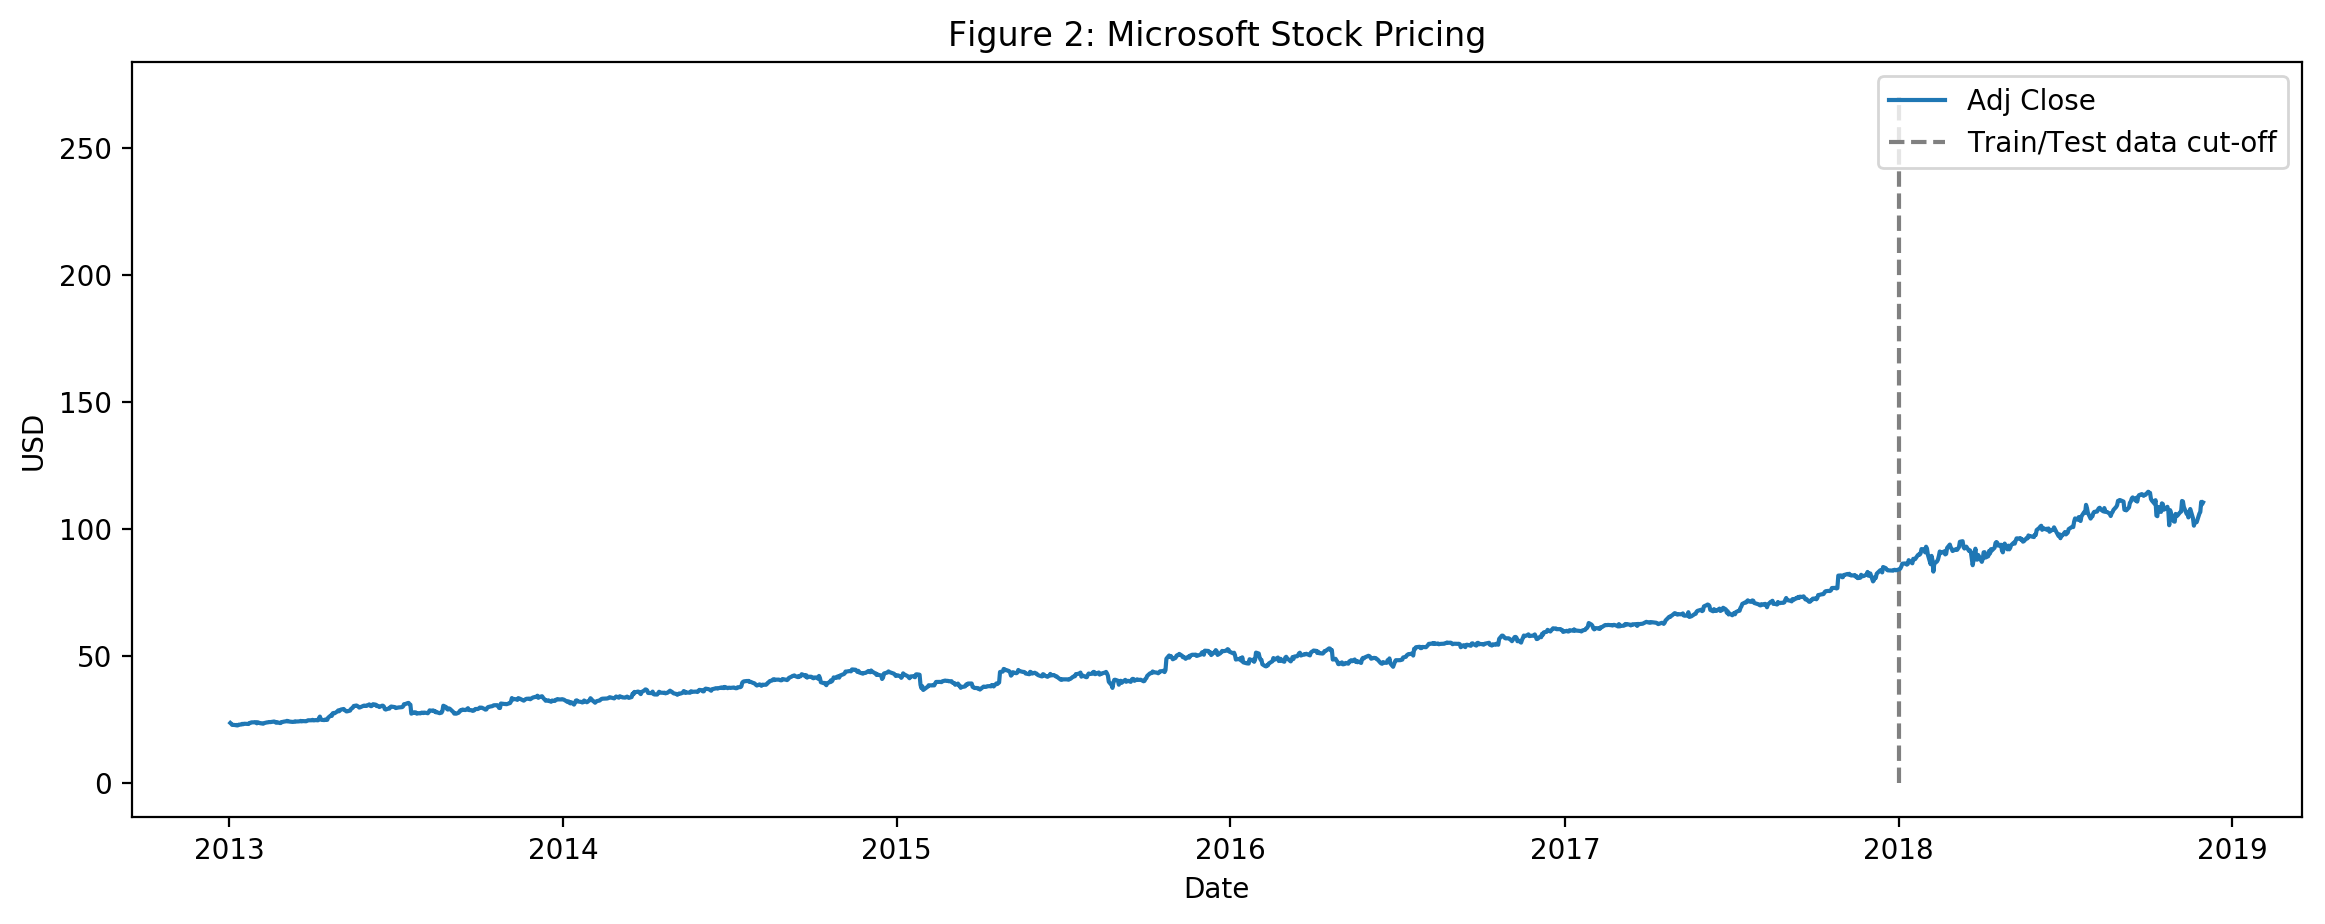

In [5]:
plt.figure(figsize=(14, 5), dpi=200)
plt.plot(stock_data_MSFT['Date'], stock_data_MSFT['Adj Close'])
plt.vlines(datetime.date(2018,1, 1), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Microsoft Stock Pricing')
plt.legend()
plt.show()

## Analyze the number of days and split training and testing days

In [6]:
num_training_days = int(stock_data_MSFT.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    stock_data_MSFT.shape[0]-num_training_days))

Number of training days: 1043. Number of test days: 448.


## Analyze the Data using Fourier Transforms

In [7]:
data_FT = stock_data_MSFT[['Date', 'Adj Close']]

In [8]:
close_fft = np.fft.fft(np.asarray(data_FT['Adj Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

## Plot the Graph for Fourier Transforms

C:\Users\NEERAJ\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


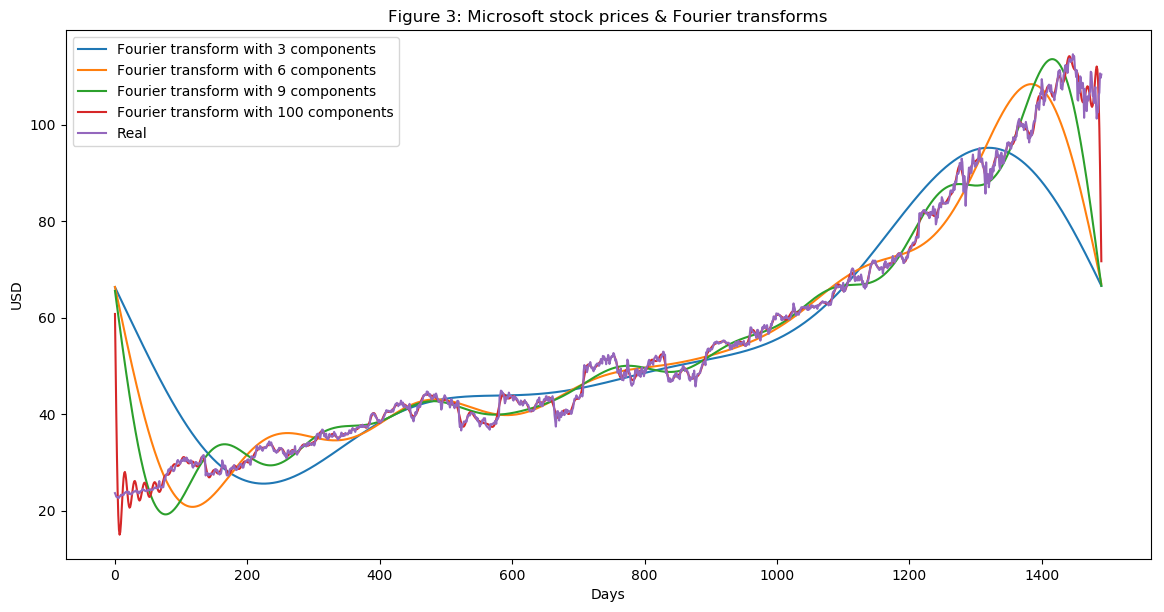

In [9]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Adj Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Microsoft stock prices & Fourier transforms')
plt.legend()
plt.show()

## Plot the Components in the Fourier Transforms

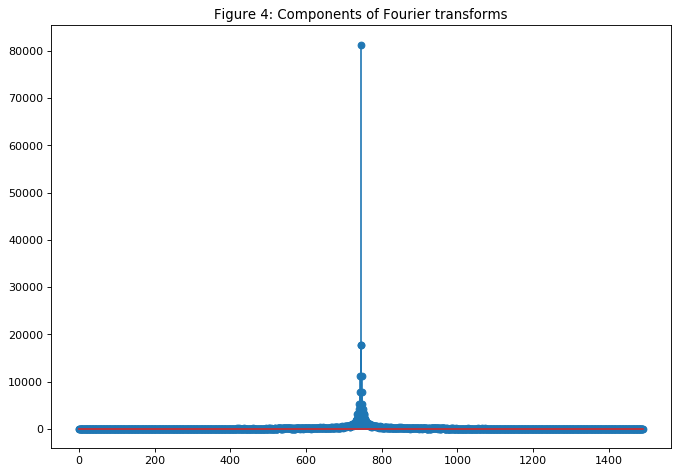

In [10]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

## Pre-process the Data and Wavelet Transforms

Here we will pre-process the data by splitting into traning and testing data and apply Wavelet Transforms to them for de-noising and preserving the time essence

In [11]:
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt


class PreProcessing:
    def __init__(self, split, feature_split):
        self.split = split
        self.feature_split = feature_split
        self.stock_data = pd.read_csv("stock_data_MSFT.csv")

    # wavelet transform and create autoencoder data
    def make_wavelet_train(self):
        train_data = []
        test_data = []
        log_train_data = []
        for i in range((len(self.stock_data)//10)*10 - 11):
            train = []
            log_ret = []
            for j in range(1, 6):
                x = np.array(self.stock_data.iloc[i: i + 11, j])
                (ca, cd) = pywt.dwt(x, "haar")
                cat = pywt.threshold(ca, np.std(ca), mode="soft")
                cdt = pywt.threshold(cd, np.std(cd), mode="soft")
                tx = pywt.idwt(cat, cdt, "haar")
                log = np.diff(np.log(tx))*100
                macd = np.mean(x[5:]) - np.mean(x)
                # ma = np.mean(x)
                sd = np.std(x)
                log_ret = np.append(log_ret, log)
                x_tech = np.append(macd*10, sd)
                train = np.append(train, x_tech)
            train_data.append(train)
            log_train_data.append(log_ret)
        trained = pd.DataFrame(train_data)
        trained.to_csv("preprocessing/indicators_MSFT.csv")
        log_train = pd.DataFrame(log_train_data, index=None)
        log_train.to_csv("preprocessing/log_train_MSFT.csv")
        # auto_train = pd.DataFrame(train_data[0:800])
        # auto_test = pd.DataFrame(train_data[801:1000])
        # auto_train.to_csv("auto_train.csv")
        # auto_test.to_csv("auto_test.csv")
        rbm_train = pd.DataFrame(log_train_data[0:int(self.split*self.feature_split*len(log_train_data))], index=None)
        rbm_train.to_csv("preprocessing/rbm_train_MSFT.csv")
        rbm_test = pd.DataFrame(log_train_data[int(self.split*self.feature_split*len(log_train_data))+1:
                                               int(self.feature_split*len(log_train_data))])
        rbm_test.to_csv("preprocessing/rbm_test_MSFT.csv")
        for i in range((len(self.stock_data) // 10) * 10 - 11):
            y = 100*np.log(self.stock_data.iloc[i + 11, 5] / self.stock_data.iloc[i + 10, 5])
            test_data.append(y)
        test = pd.DataFrame(test_data)
        test.to_csv("preprocessing/test_data_MSFT.csv")

    def make_test_data(self):
        test_stock = []
        # stock_data_test = pd.read_csv("stock_data_test.csv", index_col=0)

        for i in range((len(self.stock_data) // 10) * 10 - 11):
            l = self.stock_data.iloc[i+11, 5]
            test_stock.append(l)
            test = pd.DataFrame(test_stock)
            test.to_csv("preprocessing/test_stock_MSFT.csv")

        stock_test_data = np.array(test_stock)[int(self.feature_split*len(test_stock) +
                                               self.split*(1-self.feature_split)*len(test_stock)):]
        stock = pd.DataFrame(stock_test_data, index=None)
        stock.to_csv("stock_data_test_MSFT.csv")

        # print(train_data[1:5])
        # print(test_data[1:5])
        # plt.plot(train_data[1])
        # plt.show()


if __name__ == "__main__":
    preprocess = PreProcessing(0.8, 0.25)
    preprocess.make_wavelet_train()
    preprocess.make_test_data()


## Build And Train the Stacked AutoEncoder 

In [12]:
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
import pandas as pd
import numpy as np


class AutoEncoder:
    def __init__(self, encoding_dim):
        self.encoding_dim = encoding_dim

    def build_train_model(self, input_shape, encoded1_shape, encoded2_shape, decoded1_shape, decoded2_shape):
        input_data = Input(shape=(1, input_shape))

        encoded1 = Dense(encoded1_shape, activation="relu", activity_regularizer=regularizers.l2(0))(input_data)
        encoded2 = Dense(encoded2_shape, activation="relu", activity_regularizer=regularizers.l2(0))(encoded1)
        encoded3 = Dense(self.encoding_dim, activation="relu", activity_regularizer=regularizers.l2(0))(encoded2)
        decoded1 = Dense(decoded1_shape, activation="relu", activity_regularizer=regularizers.l2(0))(encoded3)
        decoded2 = Dense(decoded2_shape, activation="relu", activity_regularizer=regularizers.l2(0))(decoded1)
        decoded = Dense(input_shape, activation="sigmoid", activity_regularizer=regularizers.l2(0))(decoded2)

        autoencoder = Model(inputs=input_data, outputs=decoded)

        encoder = Model(input_data, encoded3)

        # Now train the model using data we already preprocessed
        autoencoder.compile(loss="mean_squared_error", optimizer="adam")

        train = pd.read_csv("preprocessing/rbm_train_MSFT.csv", index_col=0)
        ntrain = np.array(train)
        train_data = np.reshape(ntrain, (len(ntrain), 1, input_shape))

        # print(train_data)
        # autoencoder.summary()
        autoencoder.fit(train_data, train_data, epochs=1000)

        encoder.save("models/encoder_MSFT.h5")

        test = pd.read_csv("preprocessing/rbm_test_MSFT.csv", index_col=0)
        ntest = np.array(test)
        test_data = np.reshape(ntest, (len(ntest), 1, 55))

        print(autoencoder.evaluate(test_data, test_data))
        # pred = np.reshape(ntest[1], (1, 1, 75))
        # print(encoder.predict(pred))

        log_train = pd.read_csv("preprocessing/log_train_MSFT.csv", index_col=0)
        coded_train = []
        for i in range(len(log_train)):
            data = np.array(log_train.iloc[i, :])
            values = np.reshape(data, (1, 1, 55))
            coded = encoder.predict(values)
            shaped = np.reshape(coded, (20,))
            coded_train.append(shaped)

        train_coded = pd.DataFrame(coded_train)
        train_coded.to_csv("features/autoencoded_data_MSFT.csv")


if __name__ == "__main__":
    autoencoder = AutoEncoder(20)
autoencoder.build_train_model(55, 40, 30, 30, 40)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
295/295 [==============================] - 5s 16ms/step - loss: 1.6875
Epoch 2/1000
295/295 [==============================] - 0s 98us/step - loss: 1.6677
Epoch 3/1000
295/295 [==============================] - 0s 105us/step - loss: 1.6383
Epoch 4/1000
295/295 [==============================] - 0s 108us/step - loss: 1.5897
Epoch 5/1000
295/295 [==============================] - 0s 105us/step - loss: 1.5295
Epoch 6/1000
295/295 [==============================] - 0s 101us/step - loss: 1.4695
Epoch 7/1000
295/295 [==============================] - 0s 101us/step - loss: 1.4171
Epoch 8/1000
295/295 [==============================] - 0s 108us/step - loss: 1.3715
Epoch 9/1000
295/295 [==============================] - 0s 101us/step - loss: 1.3375
Epoch 10/1000
295/295 [==============================] - 0s 101us/step - loss: 1.3079
Epoch 11/1000
295/295 [========

295/295 [==============================] - 0s 91us/step - loss: 1.1491
Epoch 91/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1483
Epoch 92/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1480
Epoch 93/1000
295/295 [==============================] - 0s 91us/step - loss: 1.1480
Epoch 94/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1479
Epoch 95/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1472
Epoch 96/1000
295/295 [==============================] - 0s 98us/step - loss: 1.1466
Epoch 97/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1462
Epoch 98/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1458
Epoch 99/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1454
Epoch 100/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1451
Epoch 101/1000
295/295 [==============================] - 0s 88us/step - loss:

295/295 [==============================] - 0s 91us/step - loss: 1.1235
Epoch 186/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1230
Epoch 187/1000
295/295 [==============================] - 0s 91us/step - loss: 1.1223
Epoch 188/1000
295/295 [==============================] - 0s 91us/step - loss: 1.1221
Epoch 189/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1221
Epoch 190/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1217
Epoch 191/1000
295/295 [==============================] - 0s 88us/step - loss: 1.1210
Epoch 192/1000
295/295 [==============================] - 0s 91us/step - loss: 1.1206
Epoch 193/1000
295/295 [==============================] - 0s 98us/step - loss: 1.1205
Epoch 194/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1209
Epoch 195/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1209
Epoch 196/1000
295/295 [==============================] - 0s 91us/ste

295/295 [==============================] - 0s 98us/step - loss: 1.1108
Epoch 281/1000
295/295 [==============================] - 0s 91us/step - loss: 1.1113
Epoch 282/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1111
Epoch 283/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1109
Epoch 284/1000
295/295 [==============================] - 0s 98us/step - loss: 1.1110
Epoch 285/1000
295/295 [==============================] - 0s 98us/step - loss: 1.1106
Epoch 286/1000
295/295 [==============================] - 0s 91us/step - loss: 1.1114
Epoch 287/1000
295/295 [==============================] - 0s 98us/step - loss: 1.1111
Epoch 288/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1106
Epoch 289/1000
295/295 [==============================] - 0s 91us/step - loss: 1.1103
Epoch 290/1000
295/295 [==============================] - 0s 91us/step - loss: 1.1102
Epoch 291/1000
295/295 [==============================] - 0s 91us/ste

295/295 [==============================] - 0s 98us/step - loss: 1.1056
Epoch 376/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1055
Epoch 377/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1053
Epoch 378/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1056
Epoch 379/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1052
Epoch 380/1000
295/295 [==============================] - 0s 98us/step - loss: 1.1050
Epoch 381/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1048
Epoch 382/1000
295/295 [==============================] - 0s 91us/step - loss: 1.1049
Epoch 383/1000
295/295 [==============================] - 0s 105us/step - loss: 1.1051
Epoch 384/1000
295/295 [==============================] - 0s 101us/step - loss: 1.1049
Epoch 385/1000
295/295 [==============================] - 0s 91us/step - loss: 1.1049
Epoch 386/1000
295/295 [==============================] - 0s 95us/s

295/295 [==============================] - 0s 91us/step - loss: 1.1026
Epoch 471/1000
295/295 [==============================] - 0s 91us/step - loss: 1.1023
Epoch 472/1000
295/295 [==============================] - 0s 91us/step - loss: 1.1022
Epoch 473/1000
295/295 [==============================] - 0s 91us/step - loss: 1.1023
Epoch 474/1000
295/295 [==============================] - 0s 91us/step - loss: 1.1021
Epoch 475/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1018
Epoch 476/1000
295/295 [==============================] - 0s 98us/step - loss: 1.1018
Epoch 477/1000
295/295 [==============================] - 0s 91us/step - loss: 1.1018
Epoch 478/1000
295/295 [==============================] - 0s 88us/step - loss: 1.1020
Epoch 479/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1019
Epoch 480/1000
295/295 [==============================] - 0s 95us/step - loss: 1.1016
Epoch 481/1000
295/295 [==============================] - 0s 88us/ste

295/295 [==============================] - 0s 91us/step - loss: 1.0995
Epoch 566/1000
295/295 [==============================] - 0s 88us/step - loss: 1.0998
Epoch 567/1000
295/295 [==============================] - 0s 98us/step - loss: 1.0995
Epoch 568/1000
295/295 [==============================] - 0s 91us/step - loss: 1.0997
Epoch 569/1000
295/295 [==============================] - 0s 88us/step - loss: 1.0999
Epoch 570/1000
295/295 [==============================] - 0s 91us/step - loss: 1.1001
Epoch 571/1000
295/295 [==============================] - 0s 95us/step - loss: 1.0999
Epoch 572/1000
295/295 [==============================] - 0s 88us/step - loss: 1.1004
Epoch 573/1000
295/295 [==============================] - 0s 91us/step - loss: 1.1002
Epoch 574/1000
295/295 [==============================] - 0s 88us/step - loss: 1.0996
Epoch 575/1000
295/295 [==============================] - 0s 88us/step - loss: 1.0999
Epoch 576/1000
295/295 [==============================] - 0s 91us/ste

295/295 [==============================] - 0s 95us/step - loss: 1.0980
Epoch 661/1000
295/295 [==============================] - 0s 88us/step - loss: 1.0981
Epoch 662/1000
295/295 [==============================] - 0s 91us/step - loss: 1.0985
Epoch 663/1000
295/295 [==============================] - 0s 91us/step - loss: 1.0984
Epoch 664/1000
295/295 [==============================] - 0s 91us/step - loss: 1.0981
Epoch 665/1000
295/295 [==============================] - 0s 91us/step - loss: 1.0985
Epoch 666/1000
295/295 [==============================] - 0s 91us/step - loss: 1.0984
Epoch 667/1000
295/295 [==============================] - 0s 91us/step - loss: 1.0987
Epoch 668/1000
295/295 [==============================] - 0s 95us/step - loss: 1.0988
Epoch 669/1000
295/295 [==============================] - 0s 98us/step - loss: 1.0989
Epoch 670/1000
295/295 [==============================] - 0s 91us/step - loss: 1.0992
Epoch 671/1000
295/295 [==============================] - 0s 91us/ste

295/295 [==============================] - 0s 91us/step - loss: 1.0981
Epoch 755/1000
295/295 [==============================] - 0s 91us/step - loss: 1.0981
Epoch 756/1000
295/295 [==============================] - 0s 91us/step - loss: 1.0982
Epoch 757/1000
295/295 [==============================] - 0s 91us/step - loss: 1.0980
Epoch 758/1000
295/295 [==============================] - 0s 88us/step - loss: 1.0979
Epoch 759/1000
295/295 [==============================] - 0s 88us/step - loss: 1.0975
Epoch 760/1000
295/295 [==============================] - 0s 91us/step - loss: 1.0975
Epoch 761/1000
295/295 [==============================] - 0s 88us/step - loss: 1.0977
Epoch 762/1000
295/295 [==============================] - 0s 98us/step - loss: 1.0976
Epoch 763/1000
295/295 [==============================] - 0s 95us/step - loss: 1.0973
Epoch 764/1000
295/295 [==============================] - 0s 95us/step - loss: 1.0971
Epoch 765/1000
295/295 [==============================] - 0s 91us/ste

295/295 [==============================] - 0s 95us/step - loss: 1.0970
Epoch 850/1000
295/295 [==============================] - 0s 95us/step - loss: 1.0967
Epoch 851/1000
295/295 [==============================] - 0s 88us/step - loss: 1.0970
Epoch 852/1000
295/295 [==============================] - 0s 91us/step - loss: 1.0967
Epoch 853/1000
295/295 [==============================] - 0s 88us/step - loss: 1.0966
Epoch 854/1000
295/295 [==============================] - 0s 91us/step - loss: 1.0966
Epoch 855/1000
295/295 [==============================] - 0s 91us/step - loss: 1.0966
Epoch 856/1000
295/295 [==============================] - 0s 91us/step - loss: 1.0964
Epoch 857/1000
295/295 [==============================] - 0s 91us/step - loss: 1.0964
Epoch 858/1000
295/295 [==============================] - 0s 95us/step - loss: 1.0963
Epoch 859/1000
295/295 [==============================] - 0s 95us/step - loss: 1.0964
Epoch 860/1000
295/295 [==============================] - 0s 88us/ste

295/295 [==============================] - 0s 101us/step - loss: 1.0968
Epoch 945/1000
295/295 [==============================] - 0s 95us/step - loss: 1.0966
Epoch 946/1000
295/295 [==============================] - 0s 88us/step - loss: 1.0970
Epoch 947/1000
295/295 [==============================] - 0s 101us/step - loss: 1.0976
Epoch 948/1000
295/295 [==============================] - 0s 98us/step - loss: 1.0975
Epoch 949/1000
295/295 [==============================] - 0s 91us/step - loss: 1.0970
Epoch 950/1000
295/295 [==============================] - 0s 88us/step - loss: 1.0974
Epoch 951/1000
295/295 [==============================] - 0s 98us/step - loss: 1.0969
Epoch 952/1000
295/295 [==============================] - 0s 91us/step - loss: 1.0967
Epoch 953/1000
295/295 [==============================] - 0s 88us/step - loss: 1.0967
Epoch 954/1000
295/295 [==============================] - 0s 95us/step - loss: 1.0969
Epoch 955/1000
295/295 [==============================] - 0s 95us/s

## Process the Data for LSTM Layers after AutoEncoder Layers

In [13]:
import numpy as np
import pandas as pd


class DataProcessing:
    def __init__(self, split, feature_split):
        self.split = split
        self.feature_split = feature_split
        # self.train = pd.read_csv("train_data.csv", index_col=0)
        # print(train.tail())
        self.test = pd.read_csv("preprocessing/test_data_MSFT.csv", index_col=0)
        # print(test.tail())
        self.test_stock = pd.read_csv("preprocessing/test_stock_MSFT.csv", index_col=0)
        # self.auto_train = pd.read_csv("features/autoencoded_corrected_data.csv", index_col=0)
        self.auto_train = pd.read_csv("features/autoencoded_data_MSFT.csv", index_col=0)
        # auto_train.drop([0, 14, 16], axis=1, inplace=True)
        # auto_train.to_csv("autoencoded_corrected_data.csv", index=None)

    def make_train_data(self):
        train_data = np.array(self.auto_train)[int(self.feature_split*len(self.auto_train))+1:
                                               int((1-self.feature_split)*self.split*len(self.auto_train))]
        train_data = pd.DataFrame(train_data, index=None)
        train_data.to_csv("features/autoencoded_train_data_MSFT.csv")

    def make_test_data(self):
        test_data = np.array(self.auto_train)[int((1-self.feature_split)*self.split*len(self.auto_train) +
                                                  self.feature_split*len(self.auto_train)+1):]
        test_data = pd.DataFrame(test_data, index=None)
        test_data.to_csv("features/autoencoded_test_data_MSFT.csv")

    def make_train_y(self):
        train_y = np.array(self.test)[int(self.feature_split*len(self.auto_train))+1:
                                      int((1-self.feature_split)*self.split*len(self.auto_train))]
        train_y = pd.DataFrame(train_y, index=None)
        train_y.to_csv("features/autoencoded_train_y_MSFT.csv")

    def make_test_y(self):
        test_y = np.array(self.test)[int((1-self.feature_split)*self.split*len(self.auto_train) +
                                         self.feature_split*len(self.auto_train))+1:]
        test_y = pd.DataFrame(test_y)
        test_y.to_csv("features/autoencoded_test_y_MSFT.csv")

    def make_stock_train_y(self):
        test_y = np.array(self.test_stock)[int(self.feature_split*len(self.auto_train))+1:
                                           int((1-self.feature_split)*self.split*len(self.auto_train))]
        test_y = pd.DataFrame(test_y, index=None)
        test_y.to_csv("features/nn_stock_train_y_MSFT.csv")

    def make_stock_test_y(self):
        test_y = np.array(self.test_stock)[int((1-self.feature_split)*self.split*len(self.auto_train))+1:]
        test_y = pd.DataFrame(test_y, index=None)
        test_y.to_csv("features/nn_stock_test_y_MSFT.csv")


if __name__ == "__main__":
    process = DataProcessing(0.8, 0.25)
    process.make_test_data()
    process.make_train_data()
    process.make_train_y()
process.make_test_y()

## Use the Processed Data for LSTM Stacked AutoEncoders and Train the Model 

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/2000
517/517 [==============================] - 2s 4ms/step - loss: 3.0393 - mean_squared_error: 2.8009
Epoch 2/2000
517/517 [==============================] - 0s 382us/step - loss: 3.0206 - mean_squared_error: 2.7980
Epoch 3/2000
517/517 [==============================] - 0s 380us/step - loss: 3.0068 - mean_squared_error: 2.7941
Epoch 4/2000
517/517 [==============================] - 0s 332us/step - loss: 2.9961 - mean_squared_error: 2.7901
Epoch 5/2000
517/517 [==============================] - 0s 338us/step - loss: 2.9884 - mean_squared_error: 2.7890
Epoch 6/2000
517/517 [==============================] - 0s 519us/step - loss: 2.9781 - mean_squared_error: 2.7823
Epoch 7/2000
517/517 [==============================] - 1s 986us/step - loss: 2.9718 - mean_squared_error: 2.7803
Epoch 8/2000
517/517 [==============================] - 0s 874us/step - loss: 2.9656 - me

517/517 [==============================] - 0s 293us/step - loss: 2.7252 - mean_squared_error: 2.6596
Epoch 70/2000
517/517 [==============================] - 0s 293us/step - loss: 2.7239 - mean_squared_error: 2.6600
Epoch 71/2000
517/517 [==============================] - 0s 297us/step - loss: 2.7225 - mean_squared_error: 2.6599
Epoch 72/2000
517/517 [==============================] - 0s 287us/step - loss: 2.7190 - mean_squared_error: 2.6569
Epoch 73/2000
517/517 [==============================] - 0s 289us/step - loss: 2.7193 - mean_squared_error: 2.6576
Epoch 74/2000
517/517 [==============================] - 0s 286us/step - loss: 2.7165 - mean_squared_error: 2.6556
Epoch 75/2000
517/517 [==============================] - 0s 287us/step - loss: 2.7166 - mean_squared_error: 2.6568
Epoch 76/2000
517/517 [==============================] - 0s 270us/step - loss: 2.7145 - mean_squared_error: 2.6553
Epoch 77/2000
517/517 [==============================] - 0s 268us/step - loss: 2.7140 - mean_s

517/517 [==============================] - 0s 501us/step - loss: 2.6695 - mean_squared_error: 2.6385
Epoch 141/2000
517/517 [==============================] - 0s 275us/step - loss: 2.6704 - mean_squared_error: 2.6400
Epoch 142/2000
517/517 [==============================] - 0s 278us/step - loss: 2.6693 - mean_squared_error: 2.6386
Epoch 143/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6691 - mean_squared_error: 2.6391
Epoch 144/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6695 - mean_squared_error: 2.6398
Epoch 145/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6679 - mean_squared_error: 2.6386
Epoch 146/2000
517/517 [==============================] - 0s 274us/step - loss: 2.6685 - mean_squared_error: 2.6390
Epoch 147/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6684 - mean_squared_error: 2.6396
Epoch 148/2000
517/517 [==============================] - 0s 276us/step - loss: 2.6656 

517/517 [==============================] - 0s 268us/step - loss: 2.6488 - mean_squared_error: 2.6317
Epoch 211/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6495 - mean_squared_error: 2.6324
Epoch 212/2000
517/517 [==============================] - 0s 280us/step - loss: 2.6490 - mean_squared_error: 2.6322
Epoch 213/2000
517/517 [==============================] - 0s 286us/step - loss: 2.6503 - mean_squared_error: 2.6324
Epoch 214/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6501 - mean_squared_error: 2.6327
Epoch 215/2000
517/517 [==============================] - 0s 266us/step - loss: 2.6483 - mean_squared_error: 2.6316
Epoch 216/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6488 - mean_squared_error: 2.6323
Epoch 217/2000
517/517 [==============================] - 0s 266us/step - loss: 2.6481 - mean_squared_error: 2.6321
Epoch 218/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6492 

517/517 [==============================] - 0s 284us/step - loss: 2.6407 - mean_squared_error: 2.6304
Epoch 281/2000
517/517 [==============================] - 0s 272us/step - loss: 2.6388 - mean_squared_error: 2.6287
Epoch 282/2000
517/517 [==============================] - 0s 278us/step - loss: 2.6400 - mean_squared_error: 2.6299
Epoch 283/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6389 - mean_squared_error: 2.6290
Epoch 284/2000
517/517 [==============================] - 0s 272us/step - loss: 2.6389 - mean_squared_error: 2.6288
Epoch 285/2000
517/517 [==============================] - 0s 282us/step - loss: 2.6372 - mean_squared_error: 2.6274
Epoch 286/2000
517/517 [==============================] - 0s 266us/step - loss: 2.6379 - mean_squared_error: 2.6280
Epoch 287/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6375 - mean_squared_error: 2.6278
Epoch 288/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6388 

517/517 [==============================] - 0s 286us/step - loss: 2.6318 - mean_squared_error: 2.6262
Epoch 351/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6338 - mean_squared_error: 2.6282
Epoch 352/2000
517/517 [==============================] - 0s 266us/step - loss: 2.6329 - mean_squared_error: 2.6272
Epoch 353/2000
517/517 [==============================] - 0s 278us/step - loss: 2.6338 - mean_squared_error: 2.6282
Epoch 354/2000
517/517 [==============================] - 0s 264us/step - loss: 2.6336 - mean_squared_error: 2.6279
Epoch 355/2000
517/517 [==============================] - 0s 282us/step - loss: 2.6329 - mean_squared_error: 2.6272
Epoch 356/2000
517/517 [==============================] - 0s 284us/step - loss: 2.6332 - mean_squared_error: 2.6277
Epoch 357/2000
517/517 [==============================] - 0s 278us/step - loss: 2.6329 - mean_squared_error: 2.6275
Epoch 358/2000
517/517 [==============================] - 0s 280us/step - loss: 2.6328 

517/517 [==============================] - 0s 270us/step - loss: 2.6297 - mean_squared_error: 2.6263
Epoch 421/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6302 - mean_squared_error: 2.6267
Epoch 422/2000
517/517 [==============================] - 0s 287us/step - loss: 2.6301 - mean_squared_error: 2.6267
Epoch 423/2000
517/517 [==============================] - 0s 266us/step - loss: 2.6310 - mean_squared_error: 2.6276
Epoch 424/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6300 - mean_squared_error: 2.6265
Epoch 425/2000
517/517 [==============================] - 0s 297us/step - loss: 2.6297 - mean_squared_error: 2.6264
Epoch 426/2000
517/517 [==============================] - 0s 282us/step - loss: 2.6298 - mean_squared_error: 2.6265
Epoch 427/2000
517/517 [==============================] - 0s 278us/step - loss: 2.6297 - mean_squared_error: 2.6264
Epoch 428/2000
517/517 [==============================] - 0s 274us/step - loss: 2.6299 

517/517 [==============================] - 0s 270us/step - loss: 2.6289 - mean_squared_error: 2.6265
Epoch 491/2000
517/517 [==============================] - 0s 278us/step - loss: 2.6287 - mean_squared_error: 2.6265
Epoch 492/2000
517/517 [==============================] - 0s 264us/step - loss: 2.6290 - mean_squared_error: 2.6268
Epoch 493/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6293 - mean_squared_error: 2.6271
Epoch 494/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6284 - mean_squared_error: 2.6261
Epoch 495/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6284 - mean_squared_error: 2.6262
Epoch 496/2000
517/517 [==============================] - 0s 266us/step - loss: 2.6280 - mean_squared_error: 2.6259
Epoch 497/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6281 - mean_squared_error: 2.6261
Epoch 498/2000
517/517 [==============================] - 0s 284us/step - loss: 2.6281 

517/517 [==============================] - 0s 284us/step - loss: 2.6281 - mean_squared_error: 2.6265
Epoch 561/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6275 - mean_squared_error: 2.6259
Epoch 562/2000
517/517 [==============================] - 0s 282us/step - loss: 2.6280 - mean_squared_error: 2.6265
Epoch 563/2000
517/517 [==============================] - 0s 276us/step - loss: 2.6273 - mean_squared_error: 2.6258
Epoch 564/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6277 - mean_squared_error: 2.6262
Epoch 565/2000
517/517 [==============================] - 0s 274us/step - loss: 2.6276 - mean_squared_error: 2.6259
Epoch 566/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6276 - mean_squared_error: 2.6261
Epoch 567/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6268 - mean_squared_error: 2.6253
Epoch 568/2000
517/517 [==============================] - 0s 276us/step - loss: 2.6276 

517/517 [==============================] - 0s 270us/step - loss: 2.6271 - mean_squared_error: 2.6258
Epoch 631/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6264 - mean_squared_error: 2.6253
Epoch 632/2000
517/517 [==============================] - 0s 266us/step - loss: 2.6272 - mean_squared_error: 2.6260
Epoch 633/2000
517/517 [==============================] - 0s 272us/step - loss: 2.6272 - mean_squared_error: 2.6261
Epoch 634/2000
517/517 [==============================] - 0s 274us/step - loss: 2.6270 - mean_squared_error: 2.6258
Epoch 635/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6275 - mean_squared_error: 2.6262
Epoch 636/2000
517/517 [==============================] - 0s 266us/step - loss: 2.6267 - mean_squared_error: 2.6254
Epoch 637/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6272 - mean_squared_error: 2.6260
Epoch 638/2000
517/517 [==============================] - 0s 266us/step - loss: 2.6270 

517/517 [==============================] - 0s 274us/step - loss: 2.6269 - mean_squared_error: 2.6259
Epoch 701/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6272 - mean_squared_error: 2.6262
Epoch 702/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6266 - mean_squared_error: 2.6256
Epoch 703/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6274 - mean_squared_error: 2.6264
Epoch 704/2000
517/517 [==============================] - 0s 277us/step - loss: 2.6272 - mean_squared_error: 2.6262
Epoch 705/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6269 - mean_squared_error: 2.6259
Epoch 706/2000
517/517 [==============================] - 0s 280us/step - loss: 2.6274 - mean_squared_error: 2.6264
Epoch 707/2000
517/517 [==============================] - 0s 272us/step - loss: 2.6265 - mean_squared_error: 2.6255
Epoch 708/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6269 

517/517 [==============================] - 0s 274us/step - loss: 2.6262 - mean_squared_error: 2.6254
Epoch 771/2000
517/517 [==============================] - 0s 280us/step - loss: 2.6264 - mean_squared_error: 2.6256
Epoch 772/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6265 - mean_squared_error: 2.6257
Epoch 773/2000
517/517 [==============================] - 0s 272us/step - loss: 2.6265 - mean_squared_error: 2.6257
Epoch 774/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6262 - mean_squared_error: 2.6254
Epoch 775/2000
517/517 [==============================] - 0s 266us/step - loss: 2.6262 - mean_squared_error: 2.6254
Epoch 776/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6263 - mean_squared_error: 2.6255
Epoch 777/2000
517/517 [==============================] - 0s 264us/step - loss: 2.6264 - mean_squared_error: 2.6256
Epoch 778/2000
517/517 [==============================] - 0s 297us/step - loss: 2.6259 

517/517 [==============================] - 0s 272us/step - loss: 2.6255 - mean_squared_error: 2.6248
Epoch 841/2000
517/517 [==============================] - 0s 274us/step - loss: 2.6259 - mean_squared_error: 2.6251
Epoch 842/2000
517/517 [==============================] - 0s 266us/step - loss: 2.6266 - mean_squared_error: 2.6256
Epoch 843/2000
517/517 [==============================] - 0s 276us/step - loss: 2.6265 - mean_squared_error: 2.6255
Epoch 844/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6273 - mean_squared_error: 2.6265
Epoch 845/2000
517/517 [==============================] - 0s 278us/step - loss: 2.6256 - mean_squared_error: 2.6247
Epoch 846/2000
517/517 [==============================] - 0s 260us/step - loss: 2.6265 - mean_squared_error: 2.6257
Epoch 847/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6265 - mean_squared_error: 2.6257
Epoch 848/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6264 

517/517 [==============================] - 0s 276us/step - loss: 2.6267 - mean_squared_error: 2.6259
Epoch 910/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6259 - mean_squared_error: 2.6252
Epoch 911/2000
517/517 [==============================] - 0s 266us/step - loss: 2.6260 - mean_squared_error: 2.6253
Epoch 912/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6260 - mean_squared_error: 2.6252
Epoch 913/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6258 - mean_squared_error: 2.6249
Epoch 914/2000
517/517 [==============================] - 0s 272us/step - loss: 2.6275 - mean_squared_error: 2.6264
Epoch 915/2000
517/517 [==============================] - 0s 274us/step - loss: 2.6267 - mean_squared_error: 2.6256
Epoch 916/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6260 - mean_squared_error: 2.6249
Epoch 917/2000
517/517 [==============================] - 0s 266us/step - loss: 2.6262 

517/517 [==============================] - 0s 272us/step - loss: 2.6257 - mean_squared_error: 2.6247
Epoch 980/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6257 - mean_squared_error: 2.6247
Epoch 981/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6251 - mean_squared_error: 2.6240
Epoch 982/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6257 - mean_squared_error: 2.6248
Epoch 983/2000
517/517 [==============================] - 0s 276us/step - loss: 2.6270 - mean_squared_error: 2.6260
Epoch 984/2000
517/517 [==============================] - 0s 272us/step - loss: 2.6254 - mean_squared_error: 2.6244
Epoch 985/2000
517/517 [==============================] - 0s 262us/step - loss: 2.6248 - mean_squared_error: 2.6239
Epoch 986/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6257 - mean_squared_error: 2.6249
Epoch 987/2000
517/517 [==============================] - 0s 271us/step - loss: 2.6254 

517/517 [==============================] - 0s 287us/step - loss: 2.6247 - mean_squared_error: 2.6237
Epoch 1050/2000
517/517 [==============================] - 0s 284us/step - loss: 2.6261 - mean_squared_error: 2.6248
Epoch 1051/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6251 - mean_squared_error: 2.6240
Epoch 1052/2000
517/517 [==============================] - 0s 272us/step - loss: 2.6265 - mean_squared_error: 2.6254
Epoch 1053/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6264 - mean_squared_error: 2.6253
Epoch 1054/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6257 - mean_squared_error: 2.6247
Epoch 1055/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6254 - mean_squared_error: 2.6245
Epoch 1056/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6242 - mean_squared_error: 2.6230
Epoch 1057/2000
517/517 [==============================] - 0s 264us/step - loss:

517/517 [==============================] - 0s 285us/step - loss: 2.6209 - mean_squared_error: 2.6169
Epoch 1120/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6219 - mean_squared_error: 2.6190
Epoch 1121/2000
517/517 [==============================] - 0s 272us/step - loss: 2.6267 - mean_squared_error: 2.6242
Epoch 1122/2000
517/517 [==============================] - 0s 280us/step - loss: 2.6278 - mean_squared_error: 2.6261
Epoch 1123/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6249 - mean_squared_error: 2.6233
Epoch 1124/2000
517/517 [==============================] - 0s 278us/step - loss: 2.6216 - mean_squared_error: 2.6189
Epoch 1125/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6205 - mean_squared_error: 2.6171
Epoch 1126/2000
517/517 [==============================] - 0s 272us/step - loss: 2.6235 - mean_squared_error: 2.6208
Epoch 1127/2000
517/517 [==============================] - 0s 272us/step - loss:

517/517 [==============================] - 0s 257us/step - loss: 2.6188 - mean_squared_error: 2.6121
Epoch 1190/2000
517/517 [==============================] - 0s 258us/step - loss: 2.6163 - mean_squared_error: 2.6086
Epoch 1191/2000
517/517 [==============================] - 0s 262us/step - loss: 2.6242 - mean_squared_error: 2.6145
Epoch 1192/2000
517/517 [==============================] - 0s 255us/step - loss: 2.6257 - mean_squared_error: 2.6162
Epoch 1193/2000
517/517 [==============================] - 0s 257us/step - loss: 2.6182 - mean_squared_error: 2.6103
Epoch 1194/2000
517/517 [==============================] - 0s 262us/step - loss: 2.6213 - mean_squared_error: 2.6118
Epoch 1195/2000
517/517 [==============================] - 0s 257us/step - loss: 2.6198 - mean_squared_error: 2.6086
Epoch 1196/2000
517/517 [==============================] - 0s 257us/step - loss: 2.6190 - mean_squared_error: 2.6087
Epoch 1197/2000
517/517 [==============================] - 0s 260us/step - loss:

517/517 [==============================] - 0s 276us/step - loss: 2.6197 - mean_squared_error: 2.6122
Epoch 1260/2000
517/517 [==============================] - 0s 272us/step - loss: 2.6176 - mean_squared_error: 2.6087
Epoch 1261/2000
517/517 [==============================] - 0s 260us/step - loss: 2.6188 - mean_squared_error: 2.6086
Epoch 1262/2000
517/517 [==============================] - 0s 278us/step - loss: 2.6075 - mean_squared_error: 2.5976
Epoch 1263/2000
517/517 [==============================] - 0s 276us/step - loss: 2.6114 - mean_squared_error: 2.6024
Epoch 1264/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6193 - mean_squared_error: 2.6102
Epoch 1265/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6111 - mean_squared_error: 2.6014
Epoch 1266/2000
517/517 [==============================] - 0s 266us/step - loss: 2.6095 - mean_squared_error: 2.5986
Epoch 1267/2000
517/517 [==============================] - 0s 259us/step - loss:

517/517 [==============================] - 0s 262us/step - loss: 2.6044 - mean_squared_error: 2.5963
Epoch 1329/2000
517/517 [==============================] - 0s 266us/step - loss: 2.6160 - mean_squared_error: 2.6079
Epoch 1330/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6245 - mean_squared_error: 2.6153
Epoch 1331/2000
517/517 [==============================] - 0s 260us/step - loss: 2.6291 - mean_squared_error: 2.6201
Epoch 1332/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6068 - mean_squared_error: 2.5958
Epoch 1333/2000
517/517 [==============================] - 0s 264us/step - loss: 2.6142 - mean_squared_error: 2.6050
Epoch 1334/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6119 - mean_squared_error: 2.6027
Epoch 1335/2000
517/517 [==============================] - 0s 262us/step - loss: 2.6041 - mean_squared_error: 2.5950
Epoch 1336/2000
517/517 [==============================] - 0s 262us/step - loss:

517/517 [==============================] - 0s 268us/step - loss: 2.6392 - mean_squared_error: 2.6294
Epoch 1399/2000
517/517 [==============================] - 0s 264us/step - loss: 2.6080 - mean_squared_error: 2.5991
Epoch 1400/2000
517/517 [==============================] - 0s 262us/step - loss: 2.6060 - mean_squared_error: 2.5969
Epoch 1401/2000
517/517 [==============================] - 0s 262us/step - loss: 2.6178 - mean_squared_error: 2.6088
Epoch 1402/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6125 - mean_squared_error: 2.6040
Epoch 1403/2000
517/517 [==============================] - 0s 289us/step - loss: 2.5958 - mean_squared_error: 2.5864
Epoch 1404/2000
517/517 [==============================] - 0s 274us/step - loss: 2.6173 - mean_squared_error: 2.6081
Epoch 1405/2000
517/517 [==============================] - 0s 283us/step - loss: 2.6031 - mean_squared_error: 2.5936
Epoch 1406/2000
517/517 [==============================] - 0s 266us/step - loss:

517/517 [==============================] - 0s 278us/step - loss: 2.6178 - mean_squared_error: 2.6087
Epoch 1469/2000
517/517 [==============================] - 0s 295us/step - loss: 2.6095 - mean_squared_error: 2.5998
Epoch 1470/2000
517/517 [==============================] - 0s 276us/step - loss: 2.6025 - mean_squared_error: 2.5938
Epoch 1471/2000
517/517 [==============================] - 0s 276us/step - loss: 2.6147 - mean_squared_error: 2.6043
Epoch 1472/2000
517/517 [==============================] - 0s 274us/step - loss: 2.6080 - mean_squared_error: 2.5969
Epoch 1473/2000
517/517 [==============================] - 0s 274us/step - loss: 2.5871 - mean_squared_error: 2.5749
Epoch 1474/2000
517/517 [==============================] - 0s 274us/step - loss: 2.6103 - mean_squared_error: 2.5990
Epoch 1475/2000
517/517 [==============================] - 0s 278us/step - loss: 2.6056 - mean_squared_error: 2.5949
Epoch 1476/2000
517/517 [==============================] - 0s 278us/step - loss:

517/517 [==============================] - 0s 272us/step - loss: 2.6324 - mean_squared_error: 2.6237
Epoch 1539/2000
517/517 [==============================] - 0s 260us/step - loss: 2.5950 - mean_squared_error: 2.5858
Epoch 1540/2000
517/517 [==============================] - 0s 262us/step - loss: 2.6085 - mean_squared_error: 2.5996
Epoch 1541/2000
517/517 [==============================] - 0s 264us/step - loss: 2.6079 - mean_squared_error: 2.5958
Epoch 1542/2000
517/517 [==============================] - 0s 258us/step - loss: 2.6012 - mean_squared_error: 2.5881
Epoch 1543/2000
517/517 [==============================] - 0s 278us/step - loss: 2.6258 - mean_squared_error: 2.6137
Epoch 1544/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6301 - mean_squared_error: 2.6197
Epoch 1545/2000
517/517 [==============================] - 0s 266us/step - loss: 2.6108 - mean_squared_error: 2.6011
Epoch 1546/2000
517/517 [==============================] - 0s 274us/step - loss:

517/517 [==============================] - 0s 282us/step - loss: 2.5876 - mean_squared_error: 2.5765
Epoch 1609/2000
517/517 [==============================] - 0s 282us/step - loss: 2.5978 - mean_squared_error: 2.5853
Epoch 1610/2000
517/517 [==============================] - 0s 280us/step - loss: 2.6034 - mean_squared_error: 2.5933
Epoch 1611/2000
517/517 [==============================] - 0s 282us/step - loss: 2.6180 - mean_squared_error: 2.6076
Epoch 1612/2000
517/517 [==============================] - 0s 270us/step - loss: 2.5949 - mean_squared_error: 2.5851
Epoch 1613/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6136 - mean_squared_error: 2.6044
Epoch 1614/2000
517/517 [==============================] - 0s 274us/step - loss: 2.6193 - mean_squared_error: 2.6094
Epoch 1615/2000
517/517 [==============================] - 0s 268us/step - loss: 2.6171 - mean_squared_error: 2.6068
Epoch 1616/2000
517/517 [==============================] - 0s 274us/step - loss:

517/517 [==============================] - 0s 270us/step - loss: 2.6148 - mean_squared_error: 2.6047
Epoch 1679/2000
517/517 [==============================] - 0s 270us/step - loss: 2.5908 - mean_squared_error: 2.5802
Epoch 1680/2000
517/517 [==============================] - 0s 274us/step - loss: 2.6001 - mean_squared_error: 2.5893
Epoch 1681/2000
517/517 [==============================] - 0s 266us/step - loss: 2.6199 - mean_squared_error: 2.6088
Epoch 1682/2000
517/517 [==============================] - 0s 278us/step - loss: 2.5949 - mean_squared_error: 2.5835
Epoch 1683/2000
517/517 [==============================] - 0s 268us/step - loss: 2.5955 - mean_squared_error: 2.5833
Epoch 1684/2000
517/517 [==============================] - 0s 268us/step - loss: 2.5805 - mean_squared_error: 2.5684
Epoch 1685/2000
517/517 [==============================] - 0s 270us/step - loss: 2.5878 - mean_squared_error: 2.5755
Epoch 1686/2000
517/517 [==============================] - 0s 272us/step - loss:

517/517 [==============================] - 0s 274us/step - loss: 2.5958 - mean_squared_error: 2.5818
Epoch 1749/2000
517/517 [==============================] - 0s 272us/step - loss: 2.6160 - mean_squared_error: 2.6021
Epoch 1750/2000
517/517 [==============================] - 0s 272us/step - loss: 2.6276 - mean_squared_error: 2.6152
Epoch 1751/2000
517/517 [==============================] - 0s 270us/step - loss: 2.6092 - mean_squared_error: 2.5975
Epoch 1752/2000
517/517 [==============================] - 0s 284us/step - loss: 2.5992 - mean_squared_error: 2.5887
Epoch 1753/2000
517/517 [==============================] - 0s 291us/step - loss: 2.6137 - mean_squared_error: 2.6037
Epoch 1754/2000
517/517 [==============================] - 0s 274us/step - loss: 2.6365 - mean_squared_error: 2.6256
Epoch 1755/2000
517/517 [==============================] - 0s 291us/step - loss: 2.6050 - mean_squared_error: 2.5938
Epoch 1756/2000
517/517 [==============================] - 0s 282us/step - loss:

517/517 [==============================] - 0s 268us/step - loss: 2.6186 - mean_squared_error: 2.6058
Epoch 1819/2000
517/517 [==============================] - 0s 268us/step - loss: 2.5939 - mean_squared_error: 2.5824
Epoch 1820/2000
517/517 [==============================] - 0s 272us/step - loss: 2.6148 - mean_squared_error: 2.6031
Epoch 1821/2000
517/517 [==============================] - 0s 274us/step - loss: 2.5807 - mean_squared_error: 2.5690
Epoch 1822/2000
517/517 [==============================] - 0s 266us/step - loss: 2.6178 - mean_squared_error: 2.6056
Epoch 1823/2000
517/517 [==============================] - 0s 266us/step - loss: 2.5816 - mean_squared_error: 2.5697
Epoch 1824/2000
517/517 [==============================] - 0s 266us/step - loss: 2.6342 - mean_squared_error: 2.6241
Epoch 1825/2000
517/517 [==============================] - 0s 287us/step - loss: 2.6124 - mean_squared_error: 2.6016
Epoch 1826/2000
517/517 [==============================] - 0s 286us/step - loss:

517/517 [==============================] - 0s 293us/step - loss: 2.6147 - mean_squared_error: 2.6011
Epoch 1889/2000
517/517 [==============================] - 0s 303us/step - loss: 2.5848 - mean_squared_error: 2.5722
Epoch 1890/2000
517/517 [==============================] - 0s 303us/step - loss: 2.6110 - mean_squared_error: 2.5973
Epoch 1891/2000
517/517 [==============================] - 0s 303us/step - loss: 2.6142 - mean_squared_error: 2.6013
Epoch 1892/2000
517/517 [==============================] - 0s 314us/step - loss: 2.6057 - mean_squared_error: 2.5936
Epoch 1893/2000
517/517 [==============================] - 0s 299us/step - loss: 2.6231 - mean_squared_error: 2.6127
Epoch 1894/2000
517/517 [==============================] - 0s 316us/step - loss: 2.5879 - mean_squared_error: 2.5766
Epoch 1895/2000
517/517 [==============================] - 0s 330us/step - loss: 2.6068 - mean_squared_error: 2.5939
Epoch 1896/2000
517/517 [==============================] - 0s 287us/step - loss:

517/517 [==============================] - 0s 270us/step - loss: 2.5858 - mean_squared_error: 2.5731
Epoch 1959/2000
517/517 [==============================] - 0s 278us/step - loss: 2.6006 - mean_squared_error: 2.5868
Epoch 1960/2000
517/517 [==============================] - 0s 268us/step - loss: 2.5971 - mean_squared_error: 2.5827
Epoch 1961/2000
517/517 [==============================] - 0s 266us/step - loss: 2.6087 - mean_squared_error: 2.5962
Epoch 1962/2000
517/517 [==============================] - 0s 272us/step - loss: 2.6286 - mean_squared_error: 2.6180
Epoch 1963/2000
517/517 [==============================] - 0s 276us/step - loss: 2.5871 - mean_squared_error: 2.5762
Epoch 1964/2000
517/517 [==============================] - 0s 268us/step - loss: 2.5991 - mean_squared_error: 2.5864
Epoch 1965/2000
517/517 [==============================] - 0s 270us/step - loss: 2.5648 - mean_squared_error: 2.5504
Epoch 1966/2000
517/517 [==============================] - 0s 272us/step - loss:

C:\Users\NEERAJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


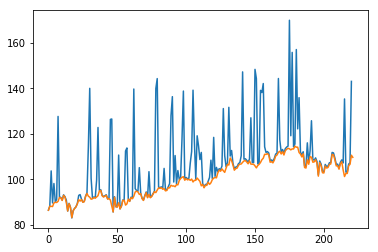

In [14]:
import keras.layers as kl
from keras.models import Model
from keras import regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.plotting import output_file, figure, show


class NeuralNetwork:
    def __init__(self, input_shape, stock_or_return):
        self.input_shape = input_shape
        self.stock_or_return = stock_or_return

    def make_train_model(self):
        input_data = kl.Input(shape=(1, self.input_shape))
        lstm = kl.LSTM(5, input_shape=(1, self.input_shape), return_sequences=True, activity_regularizer=regularizers.l2(0.003),
                       recurrent_regularizer=regularizers.l2(0), dropout=0.2, recurrent_dropout=0.2)(input_data)
        perc = kl.Dense(5, activation="sigmoid", activity_regularizer=regularizers.l2(0.005))(lstm)
        lstm2 = kl.LSTM(2, activity_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.001),
                        dropout=0.2, recurrent_dropout=0.2)(perc)
        out = kl.Dense(1, activation="sigmoid", activity_regularizer=regularizers.l2(0.001))(lstm2)

        model = Model(input_data, out)
        model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])

        # load data

        train = np.reshape(np.array(pd.read_csv("features/autoencoded_train_data_MSFT.csv", index_col=0)),
                           (len(np.array(pd.read_csv("features/autoencoded_train_data_MSFT.csv"))), 1, self.input_shape))
        train_y = np.array(pd.read_csv("features/autoencoded_train_y_MSFT.csv", index_col=0))
        # train_stock = np.array(pd.read_csv("train_stock.csv"))

        # train model

        model.fit(train, train_y, epochs=2000)

        model.save("models/model_MSFT.h5", overwrite=True, include_optimizer=True)

        test_x = np.reshape(np.array(pd.read_csv("features/autoencoded_test_data_MSFT.csv", index_col=0)),
                            (len(np.array(pd.read_csv("features/autoencoded_test_data_MSFT.csv"))), 1, self.input_shape))
        test_y = np.array(pd.read_csv("features/autoencoded_test_y_MSFT.csv", index_col=0))
        # test_stock = np.array(pd.read_csv("test_stock.csv"))

        stock_data_test = np.array(pd.read_csv("stock_data_test_MSFT.csv", index_col=0))

        print(model.evaluate(test_x, test_y))
        prediction_data = []
        stock_data = []
        for i in range(len(test_y)):
            prediction = (model.predict(np.reshape(test_x[i], (1, 1, self.input_shape))))
            prediction_data.append(np.reshape(prediction, (1,)))
            prediction_corrected = (prediction_data - np.mean(prediction_data))/np.std(prediction_data)
            stock_price = np.exp(np.reshape(prediction, (1,)))*stock_data_test[i]
            stock_data.append(stock_price[0])
        stock_data[:] = [i - (float(stock_data[0])-float(stock_data_test[0])) for i in stock_data]
        # stock_data = stock_data - stock_data[0]
        if self.stock_or_return:
            plt.plot(stock_data)
            plt.plot(stock_data_test)
            stock = pd.DataFrame(stock_data, index=None)
            stock.to_csv("sample_predictions/predicted_prices_MSFT.csv")
            stock_test = pd.DataFrame(stock_data_test, index=None)
            stock_test.to_csv("sample_predictions/actual_prices_MSFT.csv")
            # print(stock_data)
            plt.show()
        else:
            # plt.plot(prediction_corrected)
            plt.plot(prediction_data)
            # print(prediction_data)
            plt.plot(test_y)
            plt.show()


if __name__ == "__main__":
    model = NeuralNetwork(20, True)
model.make_train_model()

In [15]:
prediction_AAPL = pd.read_csv("sample_predictions/predicted_prices_MSFT.csv", header=0, index_col=0)
actual_AAPL = pd.read_csv("sample_predictions/actual_prices_MSFT.csv", header=0, index_col=0)

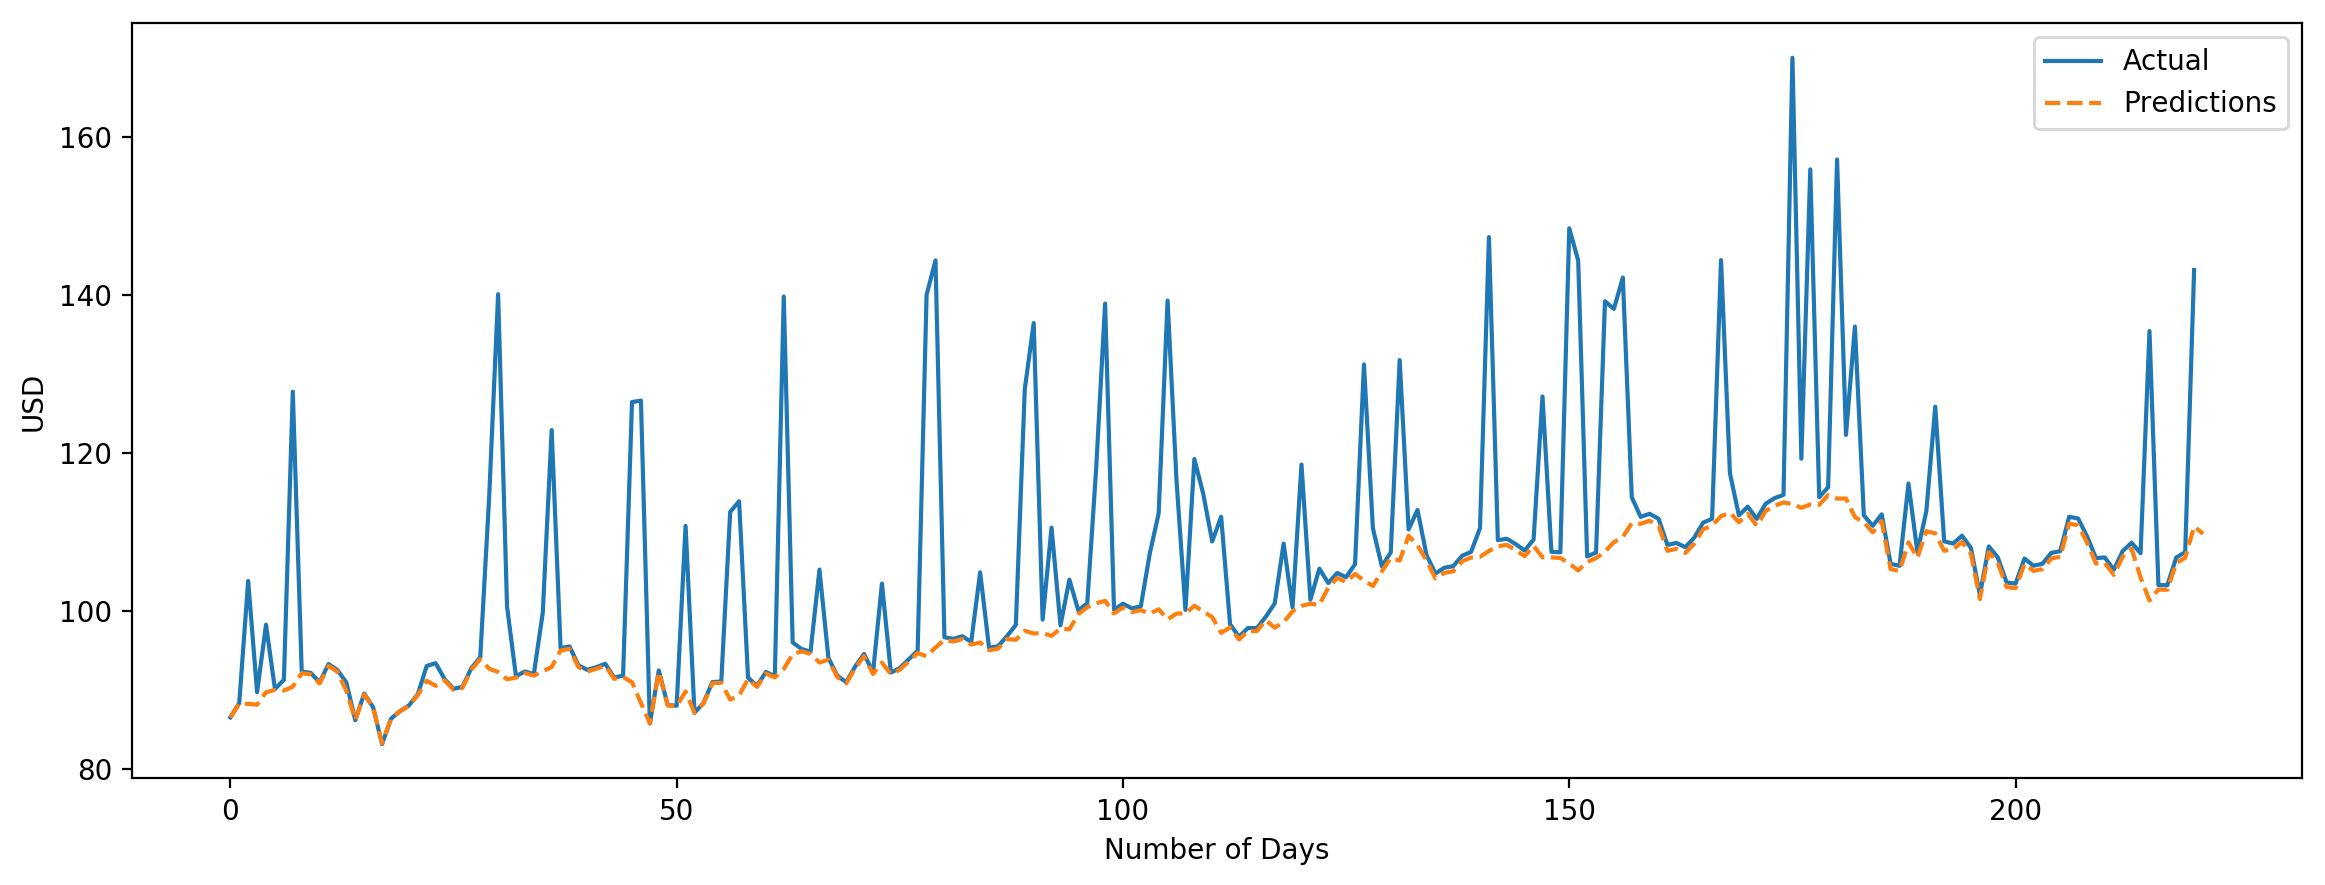

In [16]:
#plot
plt.figure(figsize=(14, 5), dpi=200)
plt.xlabel('Number of Days')
plt.ylabel('USD')
plt.plot(prediction_AAPL)
plt.plot(actual_AAPL, marker='', linestyle='dashed')
plt.legend(('Actual','Predictions'))
plt.show()

## The Above Trained Model shows better results than previously used modeling techniques as we can see from the output the plot shows the predicted values going more towards the true values